In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchtext

In [3]:
train_data=pd.read_csv('../dataset/train.csv')

In [4]:
"""The posts which dont have a body have nan token replacing that with 0"""
train_data=train_data.fillna(0)

# Body
Checking the Size of The body of Posts

Posts analysis it is found that the average(1199.09) and largest(14750) 
are extremely large passing it through a RNN Model or LSTM would be
extremely expensive. So either it needs to be truncated or Linear models like 
fastText needs to be used

In [5]:
"""Checking the length of body size"""
lenr=[]
for i in range(train_data.shape[0]):
    if train_data.loc[i,'Body']!=0:
        #print(train.loc[i,'Body'])
        lenr.append(len(train_data.loc[i,'Body']))
print(max(lenr),sum(lenr)/len(lenr))



14750 429.0718816067653


# Framework and Packages used
I chose to use torchtext and spacy for the preprocessing of text as I am working on PyTorch and these packages provide most of the utilities needed. 

## Torchtext
If it is not already installed uncomment line 1
For official documentation -https://torchtext.readthedocs.io/en/latest/

In [6]:
#pip install torchtext
import torchtext
import spacy

# Preprocessing Applied

## The Text has to preprocessed and broken into indiviual tokens from sentences before they can be embedded or sent to a model
### 1. Tokenisation
    -Done using spacy tokeniser. Better to use this rather than normal .split() method
    as it seperates punctuation attached to words like the what is (what?) and (what)
    would have been treated differently in .split method, but not with spacy
### 2. Lemmatisation
    -Also using Spacy, basically converts some word which are derived from otherwords to their root word. Like sleeping is converted to sleep.
### 3. Punctuation Removal
    -String class of python provides a list of all punctuations. Insteead of removing all punctuations, I decided to keep '?' as I think it does add some value in deciding the flair 


In [8]:
import string
k=string.punctuation

punct=[]
for i in range(len(k)):
    if(k[i]=='?'):
        continue
    else: 
        punct.append(k[i])

In [9]:
import nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [10]:
spacy_eng=spacy.load('en')
nlp=spacy.load("en_core_web_sm")
def tokenize_eng(text):
    sent=[]
    lema=nlp(text)
    for tok in spacy_eng.tokenizer(text):
        
        word=tok.lemma_
        #word=tok.text
        
        if word not in punct:
            if word not in stop:
                if(word!=word.split('_')[0]):
                    sent.extend(word.split('_'))
                else:
                    sent.append(word)
    
    return sent

Example of a Preprocessed Title

In [11]:
sent=train_data.loc[2,'Title']
sent_=tokenize_eng(sent)
print(f"Tokenised {sent_}")
print(f"Original  {[sent]}")


Tokenised ['Donald', 'Trump', 'talk', '‘', 'retaliation', '’', 'India', 'turn', 'Covid', 'drug', 'request']
Original  ['Donald Trump talks of ‘retaliation’ if India turns down Covid drug request']


## Torchtext Fields
Torchtext can be used to load the data with certain preprocessing done while loading. The way this can be done is by declaring a Field. The Field specifies how you want a certain field to be processed.

I Have defined 3 fields for different types of data in my training set
### 1. TEXT- 
For the textual data Title and body of the post
### 2. LABEL-
For the Output class Labels(Flairs)
### 3. NUM-
For numerical data like number of comments and score

In [12]:
from torchtext.data import Field

TEXT=Field(sequential=True,tokenize=tokenize_eng,lower=True,batch_first=True)
LABEL=Field(sequential=False,use_vocab=False,batch_first=True)
NUM=Field(sequential=False,use_vocab=False,batch_first=True)

In [13]:

from torchtext.data import TabularDataset

flair_fields=[('Unnamed:0',None),
        ('Unnamed: 0.1',None),
        ('idx',None),
         ('Title',TEXT),
         ('Score',NUM),
         ('ID',None),
         ('Image',None),
         ('Num_Comments',NUM),
         ('Created',None),
         ('Body',TEXT),
         ('Label1Coronovirus',LABEL),
         ('Label2Politics',LABEL),
         ('Label3Non-Political',LABEL),
         ('Label4Objects',LABEL),
         ('Label5AskIndia',LABEL)]
         

In [14]:
train_data_csv=TabularDataset(path='../dataset/train.csv',
                    format='csv',
                    skip_header=True,
                    fields=flair_fields)

In [15]:
"""Example of Datapoint """
print(f"Title- {train_data_csv[2].Title}")
print(f"Label for Coronavirus- {train_data_csv[2].Label1Coronovirus}")
print(f"Body- {train_data_csv[2].Body}")


Title- ['donald', 'trump', 'talk', '‘', 'retaliation', '’', 'india', 'turn', 'covid', 'drug', 'request']
Label for Coronavirus- 1
Body- ['0']


## Vocab Building
The TEXT Field requires a vocab using which it can numericalise the words
Now either this vocab can be made using the given dataset or can be downloaded
from a pretrained word embedding within the build_vocab feature of the Field

Here I have tried using Fasttext 300d Word Embedding and GloVe 50d.

In [ ]:
TEXT.build_vocab(train_data_csv,min_freq=1,vectors='glove.6B.50d')

In [231]:
len(TEXT.vocab)

6004

In [232]:
#Each word's representation should be 300 dim
TEXT.vocab.vectors[100].shape

torch.Size([300])

## Converting to Batches
I decided to use Mini Batch gradient descent over Batch or SGD as Batch may take alot of time in RNN and SGD may be unstable

## Iterator Used
I used BucketIterator from torchtext which has the feature to club similar sized variable together so as to minimize padding required. Here this grouping I did using Context length as that varies largely between examples ranging from 0 to 14000.

In [233]:
from torchtext.data import Iterator,BucketIterator

train_iterator=BucketIterator(train_data_csv,
                             batch_size=32,
                             device=-1,
                             sort_key=lambda x:len(x.Body),
                             sort_within_batch=True,
                             repeat=False
                             )

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [234]:
train_data_csv[1].__dict__.keys()

dict_keys(['Title', 'Score', 'Num_Comments', 'Body', 'Label1Coronovirus', 'Label2Politics', 'Label3Non-Political', 'Label4Objects', 'Label5AskIndia'])

In [235]:
"""Example of Numericalised Batch Data"""
for ex in enumerate(train_iterator):
    print(ex[1].Num_Comments)
    print(ex[1].Score)
    print(ex[1].Title.shape)
    print(ex[1].Body.shape)
    break

tensor([  7,   2,   5,   4,   3,   5,   1,   6,  39,  13,   8,  25,  48,   2,
          6,   3,   3, 201,   8,   0,  15,  25,   3,   4,   6,   8,  14,   0,
         19,  14, 337,  29])
tensor([  5,   6,   7,  11,  11,   2,  17,  10,  54,  17,  11,  35,  98,   6,
          4,   5,  13, 123,   0,   6,  12,  48,   0,  13,   5,  11,  18,   2,
         17,  24, 766,  58])
torch.Size([32, 17])
torch.Size([32, 61])


In [236]:
a=list(train_data_csv[0].__dict__.keys())
labels=a[4:]
labels

['Label1Coronovirus',
 'Label2Politics',
 'Label3Non-Political',
 'Label4Objects',
 'Label5AskIndia']

## Making a Wrapper Function for the batches
Currently the Iterator returns a function of torchtext.Batch type. Using this directly we'll need to define attributes in the train loop which will become messy and non resuable. Instead this wrapper function does that for each batch and returns a tuple of the type
####  (X[title], X[body], (X[num_comments], X[score]), y)

In [237]:
class BatchWrapper:
    def __init__(self,dat,x_var,*y_vars):
        self.dat=dat
        self.batch_size=dat.batch_size
        
        self.x_vars=x_var[0]
        self.y_vars=y_vars
        #self.context=torch.zeros((32,1000))
        self.x_vars2=x_var[1]
        
        self.x_var3=x_var[2]
        self.x_var4=x_var[3]
        
    def __iter__(self):
        for batch in self.dat:
            x=getattr(batch,self.x_vars)
            batch_siz=x.shape[0]
            
            
            x_context=getattr(batch,self.x_vars2)
            #self.context[:batch_siz,:x2.shape[1]]=x2
            y=torch.cat([getattr(batch,y).unsqueeze(1) for y in self.y_vars[0]],dim=1).float()
            
            x2=torch.cat([getattr(batch,self.x_var3).unsqueeze(1),getattr(batch,self.x_var4).unsqueeze(1)],dim=1)
            #print(x2.shape)
            yield(x,x_context,x2,y)

    def __len__(self):
        return len(self.dat)
        
train_dat=BatchWrapper(train_iterator,('Title','Body','Num_Comments','Score'),labels)

In [238]:
"""Example of the Wrapped Iterator"""
for x,y in enumerate(train_dat):
    print(x)
    print(y[1].shape)
    print(y[2].shape)
    print(y[0].shape)
    print(y[3].shape)
    break

0
torch.Size([32, 37])
torch.Size([32, 2])
torch.Size([32, 19])
torch.Size([32, 5])


In [239]:
"""Gives one training example"""
#next(train_dat.__iter__())

'Gives one training example'

## Pretrained vectors of Embedding
The weights of embedding will be copied to nn.Embedding layer. These weights are usually frozen during backprop, but I decided to not do that since many words like covid dont exist in vocab and currently have a 0 embbedding.

In [240]:
pretrained_vecs=TEXT.vocab.vectors

# Model

### Title Model
In this model I have used a BiLSTM for the Title and applied self attention(attention between last hidden state and each hidden state of the encoder)
To give importance to the usefull key words. This output is concatenated with the actual final hidden state as that is sort of the summary of the whole sentence.

### Number of Comments and Score
In addition to this the number of comments and score are also passed through a feed forward network and concatenated with the output of Title model

### Body
The output of the FastText model for Body is also conatenated with the output of the above 2 after using self attention with the final hidden state, to extract key parts in the context, as the entire context is usually not usefull

Concatenation of all these is passed through the output layer and then Probabilities of flair is found using Softmax
To use NLL Loss Log Softmax is used instead of regular softmax

## Embedding Weights
The embedding layer is basically a look up table, gets its weights from the pretrained vectors. Here usually the weights are frozen and not finetuned. 

## Finetuning Weights
Since many words related to coronavirus like covid corona didn't exist during making of vocab, hence their vectors are zeros at start. Hence to make the model learn their weights I allowed finetuning. This helped model to recognize the similarity between such words and not treat them as 0s.

In [303]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self,n_vocab,
                 pretrained_vec,
                batch_size=16,
                embedding_dim=50,
                hidden_dim=64,
                num_layer=2,
                 dropout=0.3,
                 output_dims=5,
                 second_output=16,
                bidirectional=True):
        super(Model,self).__init__()
        self.n_vocab=n_vocab
        self.batch_size=batch_size
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layer=num_layer
        self.bidirectional=bidirectional
        self.dropout=dropout
        
        self.output_dims=output_dims
        
        self.embedding=nn.Embedding(n_vocab,embedding_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        #self.embedding.weight.requires_grad=False
        
        self.second_output=nn.Linear(2,16)
        
        self.rnn=nn.LSTM(self.embedding_dim, self.hidden_dim,
                       num_layers=self.num_layer,
                       batch_first=True,bidirectional=self.bidirectional,
                        dropout=0.5)
        
       
        self.fc1=nn.Linear(hidden_dim*6+16,self.output_dims)
        
        self.dropout=nn.Dropout(dropout)
        self.logsoftmax=nn.LogSoftmax()
        
    def apply_attention(self,final_hid, all_hid):
    #final hid dim [batch,seqlen]
        final_hid=final_hid.unsqueeze(2)
    
    #Final hid_dim [batch,1,SeqLen]
        attention_scores=torch.bmm(all_hid,final_hid).squeeze(2)
        soft_attention_weights=F.softmax(attention_scores).unsqueeze(2)
        
        attention_output=torch.bmm(all_hid.permute(0,2,1),soft_attention_weights).squeeze(2)
   
        return attention_output
    
    def forward(self,data,num_data,context):
        
        embedded=self.embedding(data)
        output,(hidden_,_)=self.rnn(embedded)
        hidden_=torch.cat((hidden_[-1,:,:],hidden_[-2,:,:]),dim=1)
        
        attention_output=self.apply_attention(final_hid=hidden_,all_hid=output)
        
        concat_vec=torch.cat([hidden_,attention_output],dim=1)
        hidden=self.dropout(concat_vec)
        
        num_output=self.dropout(self.second_output(num_data))
        hidden=torch.cat([hidden,num_output],dim=1)
        
        context=self.apply_attention(final_hid=hidden_,all_hid=context)
        hidden=self.dropout(torch.cat([hidden,context],dim=1))
        
        output=self.fc1(hidden)
        
        return output

In [304]:
class fastText(nn.Module):
    def __init__(self,vocab_size,embedding_dim,
                 hidden_size,output_size,pretrained_wv):
        super(fastText,self).__init__()
        self.embedding_dim=embedding_dim
        self.pretrainedwts=pretrained_wv
        self.output_size=output_size
        self.hidden_size=hidden_size
        
        
        
        #Embedding Layer
        self.embedding=nn.Embedding(vocab_size,embedding_dim)
        self.embedding.weight.data.copy_(self.pretrainedwts)
        self.embedding.weight.requires_grad=False
        
        self.fc1=nn.Linear(self.embedding_dim,self.hidden_size)
        
        self.fc2=nn.Linear(self.hidden_size,self.output_size)
        self.softmax=nn.Softmax()

    def forward(self,x):
        embedded=self.embedding(x)
        h=self.fc1(embedded)
        z=self.fc2(h)
        return self.softmax(z,)

In [393]:
embedding_dim=300
Input_Vocab=len(TEXT.vocab)
model_context=fastText(vocab_size=Input_Vocab,
        embedding_dim=embedding_dim,
        hidden_size=1024,
        output_size=512,
        pretrained_wv=pretrained_vecs)
print(model_context)

fastText(
  (embedding): Embedding(6004, 300)
  (fc1): Linear(in_features=300, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (softmax): Softmax(dim=None)
)


In [394]:
embedding_dim=300
hidden_dim=256
enc_dropout=0.5

Input_Vocab=len(TEXT.vocab)

model=Model(n_vocab=Input_Vocab,pretrained_vec=pretrained_vecs,
            embedding_dim=embedding_dim,hidden_dim=hidden_dim,
            dropout=enc_dropout)

print(model)

Model(
  (embedding): Embedding(6004, 300)
  (second_output): Linear(in_features=2, out_features=16, bias=True)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=1552, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (logsoftmax): LogSoftmax()
)


# Training Loop

### Optimizer-
Adam- Combines advantages of Adaptive Gradient Algorithm and RMSProp
### Loss Function-
CrossEntropy loss with logsoftmax which is basically NLL Loss, which is on experimentation found to be better than BCE or BCEWithLogitsLoss

In [395]:
import tqdm
import torch.optim as optim
optimizer=optim.Adam(model.parameters())

optimizer_context=optim.Adam(model_context.parameters())
#criterion=nn.BCEWithLogitsLoss()
criterion=nn.CrossEntropyLoss()
EPOCH=2

In [396]:
epoch_loss_dat=[]
epoch_num_correct=[]

In [397]:
def train(model,model_context,train_iter):
    for epoch in range(1,20):
        running_loss=0.0
        running_corrects=0
        model.train()
        model_context.train()
        epoch_lo=0
        for x,x_context,x2,y in tqdm.tqdm(train_iter):
            optimizer.zero_grad()
            optimtizer_context.zero_grad()
            
            
            context=model_context(x_context)
            preds=model(data=x,num_data=x2.float(),context=context)
            
            
            preds=preds.squeeze(0)
            
            
            loss=criterion(preds,torch.max(y,1)[1])
            
            epoch_lo+=(torch.max(preds,1)[1]==torch.max(y,1)[1]).sum()
            
            loss.backward()
            
            optimizer.step()
            optimizer_context.step()
            running_loss+=loss.item()*x.size(0)
        epoch_loss=running_loss/train_data.shape[0]
        epoch_num_correct.append(epoch_lo)
        epoch_loss_dat.append(epoch_loss)
        print(f'Epoch :{epoch}, Training Loss: {epoch_loss}, Num_Correct={epoch_lo}')

In [398]:
train(model,model_context,train_dat)









  0%|          | 0/15 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.








  7%|▋         | 1/15 [00:00<00:05,  2.63it/s]







 13%|█▎        | 2/15 [00:00<00:04,  3.03it/s]







 20%|██        | 3/15 [00:00<00:03,  3.24it/s]







 27%|██▋       | 4/15 [00:01<00:03,  2.92it/s]







 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]







 40%|████      | 6/15 [00:02<00:04,  2.24it/s]







 47%|████▋     | 7/15 [00:0

Epoch :1, Training Loss: 1.9452654312327347, Num_Correct=111










  7%|▋         | 1/15 [00:00<00:05,  2.63it/s]







 13%|█▎        | 2/15 [00:00<00:04,  3.03it/s]







 20%|██        | 3/15 [00:00<00:03,  3.01it/s]







 27%|██▋       | 4/15 [00:02<00:07,  1.46it/s]







 33%|███▎      | 5/15 [00:03<00:06,  1.48it/s]







 40%|████      | 6/15 [00:03<00:05,  1.71it/s]







 47%|████▋     | 7/15 [00:04<00:04,  1.74it/s]







 53%|█████▎    | 8/15 [00:04<00:03,  1.92it/s]







 60%|██████    | 9/15 [00:05<00:03,  1.73it/s]







 67%|██████▋   | 10/15 [00:05<00:02,  2.07it/s]







 73%|███████▎  | 11/15 [00:05<00:02,  1.97it/s]







 80%|████████  | 12/15 [00:06<00:01,  2.07it/s]







 87%|████████▋ | 13/15 [00:06<00:00,  2.07it/s]







 93%|█████████▎| 14/15 [00:07<00:00,  2.00it/s]







100%|██████████| 15/15 [00:07<00:00,  1.89it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :2, Training Loss: 1.6847457225428575, Num_Correct=135










  7%|▋         | 1/15 [00:00<00:06,  2.27it/s]







 13%|█▎        | 2/15 [00:00<00:06,  2.12it/s]







 20%|██        | 3/15 [00:01<00:06,  1.93it/s]







 27%|██▋       | 4/15 [00:02<00:05,  1.92it/s]







 33%|███▎      | 5/15 [00:04<00:10,  1.05s/it]







 40%|████      | 6/15 [00:05<00:08,  1.08it/s]







 47%|████▋     | 7/15 [00:05<00:06,  1.19it/s]







 53%|█████▎    | 8/15 [00:06<00:05,  1.19it/s]







 60%|██████    | 9/15 [00:07<00:04,  1.29it/s]







 67%|██████▋   | 10/15 [00:07<00:03,  1.52it/s]







 73%|███████▎  | 11/15 [00:07<00:02,  1.69it/s]







 80%|████████  | 12/15 [00:08<00:01,  1.93it/s]







 87%|████████▋ | 13/15 [00:08<00:00,  2.16it/s]







 93%|█████████▎| 14/15 [00:09<00:00,  2.09it/s]







100%|██████████| 15/15 [00:09<00:00,  1.50it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :3, Training Loss: 1.5506759302308646, Num_Correct=194










  7%|▋         | 1/15 [00:00<00:08,  1.72it/s]







 13%|█▎        | 2/15 [00:01<00:07,  1.66it/s]







 20%|██        | 3/15 [00:01<00:07,  1.66it/s]







 27%|██▋       | 4/15 [00:02<00:06,  1.68it/s]







 33%|███▎      | 5/15 [00:02<00:05,  1.85it/s]







 40%|████      | 6/15 [00:03<00:04,  1.82it/s]







 47%|████▋     | 7/15 [00:04<00:04,  1.73it/s]







 53%|█████▎    | 8/15 [00:04<00:04,  1.64it/s]







 60%|██████    | 9/15 [00:05<00:03,  1.69it/s]







 67%|██████▋   | 10/15 [00:07<00:05,  1.16s/it]







 73%|███████▎  | 11/15 [00:08<00:03,  1.08it/s]







 80%|████████  | 12/15 [00:08<00:02,  1.26it/s]







 87%|████████▋ | 13/15 [00:09<00:01,  1.33it/s]







 93%|█████████▎| 14/15 [00:10<00:00,  1.16it/s]







100%|██████████| 15/15 [00:10<00:00,  1.37it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :4, Training Loss: 1.284700255061305, Num_Correct=256










  7%|▋         | 1/15 [00:00<00:07,  1.90it/s]







 13%|█▎        | 2/15 [00:01<00:07,  1.76it/s]







 20%|██        | 3/15 [00:01<00:06,  1.81it/s]







 27%|██▋       | 4/15 [00:02<00:05,  1.85it/s]







 33%|███▎      | 5/15 [00:03<00:08,  1.20it/s]







 40%|████      | 6/15 [00:04<00:06,  1.39it/s]







 47%|████▋     | 7/15 [00:04<00:05,  1.52it/s]







 53%|█████▎    | 8/15 [00:08<00:11,  1.67s/it]







 60%|██████    | 9/15 [00:09<00:07,  1.30s/it]







 67%|██████▋   | 10/15 [00:09<00:05,  1.02s/it]







 73%|███████▎  | 11/15 [00:10<00:04,  1.03s/it]







 80%|████████  | 12/15 [00:11<00:02,  1.15it/s]







 87%|████████▋ | 13/15 [00:13<00:02,  1.19s/it]







 93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]







100%|██████████| 15/15 [00:14<00:00,  1.05it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :5, Training Loss: 1.008579257678784, Num_Correct=308










  7%|▋         | 1/15 [00:01<00:14,  1.06s/it]







 13%|█▎        | 2/15 [00:01<00:11,  1.09it/s]







 20%|██        | 3/15 [00:03<00:15,  1.27s/it]







 27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]







 33%|███▎      | 5/15 [00:04<00:08,  1.17it/s]







 40%|████      | 6/15 [00:05<00:07,  1.24it/s]







 47%|████▋     | 7/15 [00:05<00:05,  1.36it/s]







 53%|█████▎    | 8/15 [00:06<00:04,  1.50it/s]







 60%|██████    | 9/15 [00:06<00:03,  1.68it/s]







 67%|██████▋   | 10/15 [00:07<00:02,  1.73it/s]







 73%|███████▎  | 11/15 [00:08<00:02,  1.67it/s]







 80%|████████  | 12/15 [00:09<00:02,  1.25it/s]







 87%|████████▋ | 13/15 [00:09<00:01,  1.35it/s]







 93%|█████████▎| 14/15 [00:16<00:02,  2.37s/it]







100%|██████████| 15/15 [00:16<00:00,  1.11s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :6, Training Loss: 0.6716432704986024, Num_Correct=349










  7%|▋         | 1/15 [00:00<00:06,  2.21it/s]







 13%|█▎        | 2/15 [00:00<00:05,  2.34it/s]







 20%|██        | 3/15 [00:05<00:21,  1.82s/it]







 27%|██▋       | 4/15 [00:06<00:16,  1.46s/it]







 33%|███▎      | 5/15 [00:07<00:12,  1.27s/it]







 40%|████      | 6/15 [00:07<00:09,  1.02s/it]







 47%|████▋     | 7/15 [00:08<00:07,  1.12it/s]







 53%|█████▎    | 8/15 [00:08<00:05,  1.30it/s]







 60%|██████    | 9/15 [00:09<00:04,  1.48it/s]







 67%|██████▋   | 10/15 [00:11<00:06,  1.25s/it]







 73%|███████▎  | 11/15 [00:12<00:04,  1.19s/it]







 80%|████████  | 12/15 [00:13<00:03,  1.05s/it]







 87%|████████▋ | 13/15 [00:14<00:01,  1.02it/s]







 93%|█████████▎| 14/15 [00:15<00:01,  1.10s/it]







100%|██████████| 15/15 [00:16<00:00,  1.12s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :7, Training Loss: 0.6418994216535863, Num_Correct=397










  7%|▋         | 1/15 [00:00<00:05,  2.36it/s]







 13%|█▎        | 2/15 [00:01<00:07,  1.68it/s]







 20%|██        | 3/15 [00:02<00:07,  1.60it/s]







 27%|██▋       | 4/15 [00:02<00:06,  1.75it/s]







 33%|███▎      | 5/15 [00:03<00:06,  1.51it/s]







 40%|████      | 6/15 [00:04<00:06,  1.50it/s]







 47%|████▋     | 7/15 [00:04<00:05,  1.46it/s]







 53%|█████▎    | 8/15 [00:13<00:22,  3.17s/it]







 60%|██████    | 9/15 [00:16<00:18,  3.03s/it]







 67%|██████▋   | 10/15 [00:17<00:11,  2.29s/it]







 73%|███████▎  | 11/15 [00:17<00:07,  1.76s/it]







 80%|████████  | 12/15 [00:18<00:04,  1.39s/it]







 87%|████████▋ | 13/15 [00:19<00:02,  1.43s/it]







 93%|█████████▎| 14/15 [00:20<00:01,  1.16s/it]







100%|██████████| 15/15 [00:20<00:00,  1.40s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :8, Training Loss: 0.2734659655653649, Num_Correct=429










  7%|▋         | 1/15 [00:00<00:10,  1.29it/s]







 13%|█▎        | 2/15 [00:01<00:10,  1.28it/s]







 20%|██        | 3/15 [00:02<00:11,  1.04it/s]







 27%|██▋       | 4/15 [00:03<00:08,  1.24it/s]







 33%|███▎      | 5/15 [00:09<00:25,  2.54s/it]







 40%|████      | 6/15 [00:10<00:17,  1.96s/it]







 47%|████▋     | 7/15 [00:11<00:12,  1.61s/it]







 53%|█████▎    | 8/15 [00:12<00:10,  1.56s/it]







 60%|██████    | 9/15 [00:13<00:07,  1.26s/it]







 67%|██████▋   | 10/15 [00:14<00:06,  1.25s/it]







 73%|███████▎  | 11/15 [00:15<00:04,  1.06s/it]







 80%|████████  | 12/15 [00:15<00:02,  1.13it/s]







 87%|████████▋ | 13/15 [00:16<00:01,  1.30it/s]







 93%|█████████▎| 14/15 [00:17<00:00,  1.26it/s]







100%|██████████| 15/15 [00:17<00:00,  1.18s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :9, Training Loss: 0.24206245833925163, Num_Correct=443










  7%|▋         | 1/15 [00:00<00:08,  1.65it/s]







 13%|█▎        | 2/15 [00:01<00:07,  1.77it/s]







 20%|██        | 3/15 [00:01<00:06,  1.84it/s]







 27%|██▋       | 4/15 [00:02<00:06,  1.64it/s]







 33%|███▎      | 5/15 [00:03<00:08,  1.15it/s]







 40%|████      | 6/15 [00:04<00:07,  1.17it/s]







 47%|████▋     | 7/15 [00:05<00:06,  1.19it/s]







 53%|█████▎    | 8/15 [00:06<00:05,  1.18it/s]







 60%|██████    | 9/15 [00:06<00:04,  1.42it/s]







 67%|██████▋   | 10/15 [00:07<00:03,  1.56it/s]







 73%|███████▎  | 11/15 [00:07<00:02,  1.65it/s]







 80%|████████  | 12/15 [00:10<00:03,  1.19s/it]







 87%|████████▋ | 13/15 [00:10<00:02,  1.02s/it]







 93%|█████████▎| 14/15 [00:11<00:00,  1.20it/s]







100%|██████████| 15/15 [00:21<00:00,  1.45s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :10, Training Loss: 0.2772917838778985, Num_Correct=443










  7%|▋         | 1/15 [00:00<00:12,  1.15it/s]







 13%|█▎        | 2/15 [00:10<00:45,  3.53s/it]







 20%|██        | 3/15 [00:10<00:30,  2.57s/it]







 27%|██▋       | 4/15 [00:11<00:21,  1.97s/it]







 33%|███▎      | 5/15 [00:12<00:16,  1.62s/it]







 40%|████      | 6/15 [00:12<00:11,  1.27s/it]







 47%|████▋     | 7/15 [00:13<00:08,  1.10s/it]







 53%|█████▎    | 8/15 [00:15<00:09,  1.43s/it]







 60%|██████    | 9/15 [00:16<00:06,  1.14s/it]







 67%|██████▋   | 10/15 [00:16<00:04,  1.09it/s]







 73%|███████▎  | 11/15 [00:17<00:03,  1.26it/s]







 80%|████████  | 12/15 [00:17<00:02,  1.42it/s]







 87%|████████▋ | 13/15 [00:17<00:01,  1.62it/s]







 93%|█████████▎| 14/15 [00:18<00:00,  1.69it/s]







100%|██████████| 15/15 [00:19<00:00,  1.31s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :11, Training Loss: 0.20474798714320705, Num_Correct=458










  7%|▋         | 1/15 [00:00<00:10,  1.29it/s]







 13%|█▎        | 2/15 [00:01<00:09,  1.36it/s]







 20%|██        | 3/15 [00:01<00:07,  1.54it/s]







 27%|██▋       | 4/15 [00:02<00:06,  1.82it/s]







 33%|███▎      | 5/15 [00:07<00:18,  1.87s/it]







 40%|████      | 6/15 [00:09<00:17,  1.89s/it]







 47%|████▋     | 7/15 [00:09<00:11,  1.47s/it]







 53%|█████▎    | 8/15 [00:10<00:08,  1.18s/it]







 60%|██████    | 9/15 [00:11<00:06,  1.13s/it]







 67%|██████▋   | 10/15 [00:11<00:04,  1.14it/s]







 73%|███████▎  | 11/15 [00:11<00:03,  1.31it/s]







 80%|████████  | 12/15 [00:12<00:02,  1.37it/s]







 87%|████████▋ | 13/15 [00:13<00:01,  1.51it/s]







 93%|█████████▎| 14/15 [00:13<00:00,  1.81it/s]







100%|██████████| 15/15 [00:13<00:00,  1.10it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :12, Training Loss: 0.1144143131189442, Num_Correct=462










  7%|▋         | 1/15 [00:00<00:06,  2.08it/s]







 13%|█▎        | 2/15 [00:00<00:05,  2.24it/s]







 20%|██        | 3/15 [00:01<00:06,  1.95it/s]







 27%|██▋       | 4/15 [00:01<00:05,  2.00it/s]







 33%|███▎      | 5/15 [00:02<00:05,  1.86it/s]







 40%|████      | 6/15 [00:10<00:24,  2.72s/it]







 47%|████▋     | 7/15 [00:10<00:16,  2.01s/it]







 53%|█████▎    | 8/15 [00:12<00:13,  1.93s/it]







 60%|██████    | 9/15 [00:13<00:09,  1.51s/it]







 67%|██████▋   | 10/15 [00:13<00:06,  1.23s/it]







 73%|███████▎  | 11/15 [00:14<00:04,  1.13s/it]







 80%|████████  | 12/15 [00:15<00:02,  1.06it/s]







 87%|████████▋ | 13/15 [00:15<00:01,  1.35it/s]







 93%|█████████▎| 14/15 [00:15<00:00,  1.54it/s]







100%|██████████| 15/15 [00:16<00:00,  1.09s/it]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :13, Training Loss: 0.14178143320388573, Num_Correct=458










  7%|▋         | 1/15 [00:00<00:05,  2.40it/s]







 13%|█▎        | 2/15 [00:00<00:05,  2.17it/s]







 20%|██        | 3/15 [00:01<00:05,  2.11it/s]







 27%|██▋       | 4/15 [00:01<00:05,  2.10it/s]







 33%|███▎      | 5/15 [00:02<00:05,  1.89it/s]







 40%|████      | 6/15 [00:02<00:04,  2.20it/s]







 47%|████▋     | 7/15 [00:03<00:03,  2.09it/s]







 53%|█████▎    | 8/15 [00:03<00:03,  2.06it/s]







 60%|██████    | 9/15 [00:04<00:02,  2.06it/s]







 67%|██████▋   | 10/15 [00:05<00:02,  1.87it/s]







 73%|███████▎  | 11/15 [00:05<00:02,  1.59it/s]







 80%|████████  | 12/15 [00:12<00:07,  2.55s/it]







 87%|████████▋ | 13/15 [00:13<00:03,  1.85s/it]







 93%|█████████▎| 14/15 [00:14<00:01,  1.56s/it]







100%|██████████| 15/15 [00:14<00:00,  1.05it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :14, Training Loss: 0.08774343329672771, Num_Correct=466










  7%|▋         | 1/15 [00:00<00:02,  4.79it/s]







 13%|█▎        | 2/15 [00:00<00:03,  3.82it/s]







 20%|██        | 3/15 [00:00<00:03,  3.89it/s]







 27%|██▋       | 4/15 [00:01<00:03,  3.60it/s]







 33%|███▎      | 5/15 [00:01<00:02,  3.51it/s]







 40%|████      | 6/15 [00:01<00:02,  3.26it/s]







 47%|████▋     | 7/15 [00:02<00:02,  3.49it/s]







 53%|█████▎    | 8/15 [00:02<00:02,  2.81it/s]







 60%|██████    | 9/15 [00:04<00:04,  1.40it/s]







 67%|██████▋   | 10/15 [00:04<00:03,  1.49it/s]







 73%|███████▎  | 11/15 [00:05<00:02,  1.59it/s]







 80%|████████  | 12/15 [00:06<00:02,  1.46it/s]







 87%|████████▋ | 13/15 [00:06<00:01,  1.61it/s]







 93%|█████████▎| 14/15 [00:06<00:00,  1.73it/s]







100%|██████████| 15/15 [00:13<00:00,  1.11it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :15, Training Loss: 0.04832268674536972, Num_Correct=468










  7%|▋         | 1/15 [00:00<00:05,  2.45it/s]







 13%|█▎        | 2/15 [00:00<00:04,  2.62it/s]







 20%|██        | 3/15 [00:02<00:08,  1.34it/s]







 27%|██▋       | 4/15 [00:02<00:07,  1.49it/s]







 33%|███▎      | 5/15 [00:03<00:06,  1.65it/s]







 40%|████      | 6/15 [00:03<00:04,  2.01it/s]







 47%|████▋     | 7/15 [00:04<00:04,  1.69it/s]







 53%|█████▎    | 8/15 [00:04<00:03,  1.75it/s]







 60%|██████    | 9/15 [00:05<00:03,  1.86it/s]







 67%|██████▋   | 10/15 [00:05<00:02,  1.79it/s]







 73%|███████▎  | 11/15 [00:06<00:02,  1.67it/s]







 80%|████████  | 12/15 [00:13<00:07,  2.36s/it]







 87%|████████▋ | 13/15 [00:13<00:03,  1.82s/it]







 93%|█████████▎| 14/15 [00:14<00:01,  1.41s/it]







100%|██████████| 15/15 [00:14<00:00,  1.03it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :16, Training Loss: 0.032316966431242974, Num_Correct=468










  7%|▋         | 1/15 [00:00<00:07,  1.98it/s]







 13%|█▎        | 2/15 [00:01<00:07,  1.83it/s]







 20%|██        | 3/15 [00:02<00:10,  1.16it/s]







 27%|██▋       | 4/15 [00:03<00:08,  1.29it/s]







 33%|███▎      | 5/15 [00:08<00:20,  2.04s/it]







 40%|████      | 6/15 [00:08<00:13,  1.52s/it]







 47%|████▋     | 7/15 [00:08<00:09,  1.14s/it]







 53%|█████▎    | 8/15 [00:09<00:05,  1.17it/s]







 60%|██████    | 9/15 [00:09<00:04,  1.48it/s]







 67%|██████▋   | 10/15 [00:09<00:03,  1.62it/s]







 73%|███████▎  | 11/15 [00:10<00:02,  1.89it/s]







 80%|████████  | 12/15 [00:10<00:01,  2.28it/s]







 87%|████████▋ | 13/15 [00:10<00:00,  2.43it/s]







 93%|█████████▎| 14/15 [00:11<00:00,  2.54it/s]







100%|██████████| 15/15 [00:11<00:00,  1.31it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :17, Training Loss: 0.07451378272690792, Num_Correct=461










  7%|▋         | 1/15 [00:00<00:04,  3.26it/s]







 13%|█▎        | 2/15 [00:00<00:04,  2.70it/s]







 20%|██        | 3/15 [00:06<00:23,  2.00s/it]







 27%|██▋       | 4/15 [00:07<00:17,  1.56s/it]







 33%|███▎      | 5/15 [00:07<00:13,  1.34s/it]







 40%|████      | 6/15 [00:08<00:09,  1.10s/it]







 47%|████▋     | 7/15 [00:08<00:06,  1.15it/s]







 53%|█████▎    | 8/15 [00:09<00:05,  1.32it/s]







 60%|██████    | 9/15 [00:09<00:03,  1.52it/s]







 67%|██████▋   | 10/15 [00:10<00:02,  1.68it/s]







 73%|███████▎  | 11/15 [00:11<00:03,  1.08it/s]







 80%|████████  | 12/15 [00:12<00:02,  1.19it/s]







 87%|████████▋ | 13/15 [00:12<00:01,  1.46it/s]







 93%|█████████▎| 14/15 [00:13<00:00,  1.58it/s]







100%|██████████| 15/15 [00:13<00:00,  1.07it/s]








  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :18, Training Loss: 0.054579098856600346, Num_Correct=466










  7%|▋         | 1/15 [00:00<00:07,  1.96it/s]







 13%|█▎        | 2/15 [00:01<00:06,  1.92it/s]







 20%|██        | 3/15 [00:01<00:06,  1.91it/s]







 27%|██▋       | 4/15 [00:02<00:05,  1.97it/s]







 33%|███▎      | 5/15 [00:07<00:20,  2.00s/it]







 40%|████      | 6/15 [00:07<00:13,  1.51s/it]







 47%|████▋     | 7/15 [00:08<00:09,  1.15s/it]







 53%|█████▎    | 8/15 [00:08<00:06,  1.11it/s]







 60%|██████    | 9/15 [00:09<00:04,  1.26it/s]







 67%|██████▋   | 10/15 [00:09<00:03,  1.42it/s]







 73%|███████▎  | 11/15 [00:10<00:02,  1.35it/s]







 80%|████████  | 12/15 [00:10<00:01,  1.52it/s]







 87%|████████▋ | 13/15 [00:11<00:01,  1.75it/s]







 93%|█████████▎| 14/15 [00:12<00:00,  1.21it/s]







100%|██████████| 15/15 [00:13<00:00,  1.13it/s]

Epoch :19, Training Loss: 0.037443583361591835, Num_Correct=466


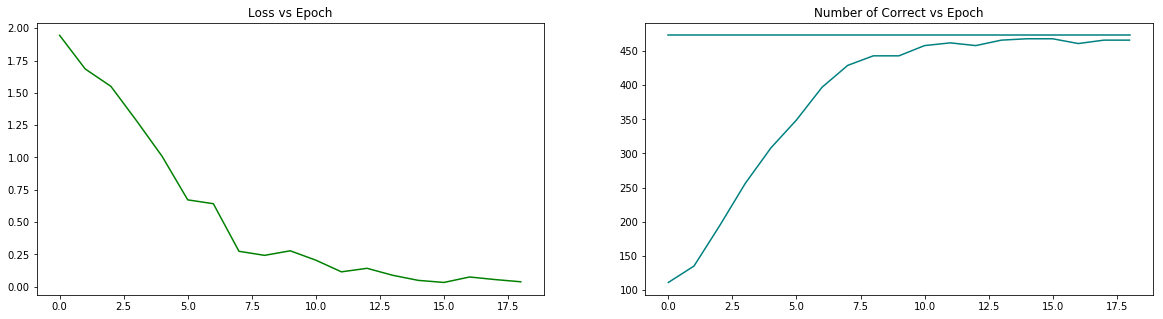

In [400]:
a=np.arange(19)
b=np.ones(19)*473
figs,axs=plt.subplots(1,2,figsize=(20,5))

axs[0].title.set_text('Loss vs Epoch')
axs[0].plot(a,epoch_loss_dat,color='g')

plt.title('Number of Correct vs Epoch')
axs[1].plot(a,b,epoch_num_correct,color='teal')
plt.show()

In [401]:
def evaluate(model,model_context,valid_iter,val_data_len):
    running_loss=0.0
    
    model.eval()
    model_context.eval()
    epoch_lo=0
    for x,x_context,x2,y in tqdm.tqdm(valid_iter):
        
        context=model_context(x_context)
        preds=model(data=x,num_data=x2.float(),context=context)
        
        preds=preds.squeeze(0)

        loss=criterion(preds,torch.max(y,1)[1])
        print((torch.max(preds,1)[1]==torch.max(y,1)[1]).sum())
        epoch_lo+=(torch.max(preds,1)[1]==torch.max(y,1)[1]).sum()
        #print(epoch_lo)
        running_loss+=loss.item()*x.shape[0]
    
    total_loss=running_loss/val_data_len
    print(f'Validation Loss: {total_loss}, Num_Correct={epoch_lo}')

In [402]:
val_data_pd=pd.read_csv('Val_data')

In [404]:
from torchtext.data import TabularDataset

validation_flair_fields=[('Unnamed:0',None),('idx',None),('Title',TEXT),
         ('Score',NUM),('ID',None),('Image',None),('Num_Comments',NUM),('Created',None),('Body',TEXT),
         ('Label1Coronovirus',LABEL),('Label2Politics',LABEL),('Label3Non-Political',LABEL),
         ('Label4Objects',LABEL),('Label5AskIndia',LABEL)]

In [405]:
val_data_csv=TabularDataset(path='../dataset/Val_data',
                    format='csv',
                    skip_header=True,
                    fields=validation_flair_fields)

In [406]:
from torchtext.data import Iterator,BucketIterator

val_iterator=BucketIterator(val_data_csv,
                             batch_size=32,
                             device=torch.device('cpu'),
                             sort_key=lambda x:len(x.Body),
                             sort_within_batch=True,
                             repeat=False
                             )

In [407]:
val_data=BatchWrapper(val_iterator,('Title','Body','Num_Comments','Score'),labels)

In [408]:
evaluate(model,model_context,val_data,val_data_pd.shape[0])









  0%|          | 0/20 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.








 10%|█         | 2/20 [00:00<00:01,  9.83it/s]

tensor(12)
tensor(14)
tensor(13)










 20%|██        | 4/20 [00:00<00:01, 10.39it/s]







 30%|███       | 6/20 [00:00<00:01, 11.36it/s]

tensor(14)
tensor(15)
tensor(6)










 40%|████      | 8/20 [00:00<00:01, 11.81it/s]

tensor(13)
tensor(14)
tensor(12)










 50%|█████     | 10/20 [00:00<00:00, 11.67it/s]

tensor(15)
tensor(7)










 60%|██████    | 12/20 [00:01<00:00, 10.99it/s]

tensor(12)
tensor(17)










 70%|███████   | 14/20 [00:01<00:00, 10.26it/s]







 75%|███████▌  | 15/20 [00:01<00:00,  8.20it/s]

tensor(16)
tensor(17)










 85%|████████▌ | 17/20 [00:01<00:00,  8.82it/s]

tensor(9)
tensor(14)
tensor(13)










 95%|█████████▌| 19/20 [00:01<00:00,  7.51it/s]







100%|██████████| 20/20 [00:02<00:00,  9.49it/s]

tensor(6)
tensor(10)
Validation Loss: 3.1897066691905307, Num_Correct=249


In [ ]:
"""The embedding vector of covid before and after training"""

print(TEXT.vocab.vectors[395])
print(model.embedding.weight[395])